In [1]:
library(tidyverse)
library(cowplot)
theme_set(theme_cowplot())
library(ggupset)

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA), # get rid of legend panel bg
                           strip.background = element_rect(fill="transparent", color = NA)
)

rslt <- '../results/'
detected_palette <- c('Yes' = 'grey80', 'No' = '#e34a33')

make_key <- function(a1, a2) {
    cbind(a1, a2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_')
}

── Attaching packages ───────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
snp_compare <- function(ds) {
    
    wBiofilter <- read_csv(paste0(rslt, 'withBiofilter_filter/', tolower(ds), '/sign_SNPPairs.txt'), col_types = 'ccdccc') %>%
        mutate(uniq_snp_id = cbind(SNP_1, SNP_2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = 'with Biofilter') %>%
        rename(pvalue = pvalue_corrected_MT) %>%
        select(uniq_snp_id, pvalue) %>%
        unique
    
    woBiofilter <- read_csv(paste0(rslt, 'withoutBiofilter_filter/', tolower(ds), '/sign_SNPPairs.txt'), col_types = 'ccdccc') %>%
        mutate(uniq_snp_id = cbind(SNP_1, SNP_2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = 'without Biofilter') %>%
        select(uniq_snp_id, pvalue) %>%
        unique

    full_join(wBiofilter, woBiofilter, by = 'uniq_snp_id', suffix = c('_wBiofilter', '_woBiofilter')) %>%
        mutate(where = ds,
               wBiofilter = ifelse(!is.na(pvalue_wBiofilter), 'Yes', 'No'),
               woBiofilter = ifelse(!is.na(pvalue_woBiofilter), 'Yes', 'No'))
    
}

snp_comparison <- bind_rows(snp_compare('eQTL'),
                            snp_compare('Chromatin'),
#                             snp_compare('eqtl_chrom'),
                            snp_compare('eqtl_chrom_phys')) %>%
    mutate(where = ifelse(where == 'eqtl_chrom', 'eQTL +\nChromatin', where),
           where = ifelse(where == 'eqtl_chrom_phys', 'Positional +\neQTL +\nChromatin', where)) %>%
    filter(wBiofilter == 'Yes') %>%
    ggplot(aes(x = where, fill = woBiofilter)) +
        geom_bar() +
        labs(x = 'Analysis', y = 'Significant SNP models', fill = 'Detected\nwithout Biofilter') +
        theme_bw() +
        theme(legend.position = 'bottom',
              axis.title=element_text(size=13)) +
        scale_fill_manual(values = detected_palette)

In [3]:
gene_compare <- function(ds) {
    
    wBiofilter <- read_csv(paste0(rslt, 'withBiofilter_filter/', tolower(ds), '/sign_GenePairs.txt'), col_types = 'cdccd') %>%
        separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
        mutate(uniq_snp_id = cbind(SNP1, SNP2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               uniq_gene_id = cbind(gene1, gene2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = 'with Biofilter') %>%
        select(uniq_gene_id, where)
    woBiofilter <- read_csv(paste0(rslt, 'withoutBiofilter_filter/', tolower(ds), '/sign_GenePairs.txt'), col_types = 'cdccd') %>%
        separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
        mutate(uniq_snp_id = cbind(SNP1, SNP2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               uniq_gene_id = cbind(gene1, gene2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = 'without Biofilter') %>%
        select(uniq_gene_id, where)

    full_join(wBiofilter, woBiofilter, by = 'uniq_gene_id', suffix = c('_wBiofilter', '_woBiofilter')) %>%
        mutate(ds = ds,
               wBiofilter = ifelse(!is.na(where_wBiofilter), 'Yes', 'No'),
               woBiofilter = ifelse(!is.na(where_woBiofilter), 'Yes', 'No'))
    
}

gene_comparison <- bind_rows(gene_compare('Chromatin'),
                             gene_compare('eQTL'),
#                              gene_compare('eqtl_chrom'),
                             gene_compare('eqtl_chrom_phys')) %>%
    mutate(ds = ifelse(ds == 'eqtl_chrom', 'eQTL +\nChromatin', ds),
           ds = ifelse(ds == 'eqtl_chrom_phys', 'Positional +\neQTL +\nChromatin', ds)) %>%
    filter(wBiofilter == 'Yes') %>%
    ggplot(aes(x = ds, fill = woBiofilter)) +
        geom_bar() +
        labs(x = 'Analysis', y = 'Significant gene models', fill = 'Detected without Biofilter') +
        theme_bw() +
        theme(legend.position = 'none',
              axis.title=element_text(size=13)) +
        scale_fill_manual(values = detected_palette)

In [4]:
read_snps <- function(ds) {
    
    read_csv(paste0(rslt, 'withBiofilter_filter/', tolower(ds), '/sign_SNPPairs.txt'), col_types = 'ccdccc') %>%
        mutate(uniq_snp_id = cbind(SNP_1, SNP_2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = ds) %>%
        rename(pvalue = pvalue_corrected_MT) %>%
        select(uniq_snp_id, pvalue, where) %>%
        unique
    
}

filter_snp <- bind_rows(read_snps('chromatin'),
                        read_snps('eqtl'),
#                         read_snps('eqtl_chrom'),
#                         read_snps('chromatin_positional'),
#                         read_snps('eqtl_positional'),
                        read_snps('eqtl_chrom_phys')) %>%
    group_by(uniq_snp_id) %>%
    summarize(eQTL = 'eqtl' %in% where,
              Chromatin = 'chromatin' %in% where,
              `eQTL + Chromatin` = 'eqtl_chrom' %in% where,
              `Positional + Chromatin` = 'chromatin_positional' %in% where,
              `Positional + eQTL` = 'eqtl_positional' %in% where,
              `Positional + eQTL + Chromatin` = 'eqtl_chrom_phys' %in% where) %>%
    gather(key = 'where', value = 'detected', -uniq_snp_id) %>%
    group_by(uniq_snp_id) %>%
    filter(detected) %>%
    summarize(Analysis = list(where)) %>%
    ggplot(aes(x = Analysis)) +
        geom_bar() +
        scale_x_upset(sets = c('eQTL', 'Chromatin', 'eQTL + Chromatin', 
                               'Positional + eQTL',
                               'Positional + Chromatin',
                               'Positional + eQTL + Chromatin')) +
        labs(y = 'Significant SNP models')

In [5]:
read_genes <- function(ds) {
    
    read_csv(paste0(rslt, 'withBiofilter_filter/', tolower(ds), '/sign_GenePairs.txt'), col_types = 'cdccd') %>%
        separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
        mutate(uniq_gene_id = cbind(gene1, gene2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               where = ds) %>%
        select(uniq_gene_id, where) %>%
        unique
    
}

filter_genes <- bind_rows(read_genes('chromatin'),
                          read_genes('eqtl'),
#                           read_genes('eqtl_chrom'),
#                           read_genes('chromatin_positional'),
#                           read_genes('eqtl_positional'),
                          read_genes('eqtl_chrom_phys')) %>%
    group_by(uniq_gene_id) %>%
    summarize(eQTL = 'eqtl' %in% where,
              Chromatin = 'chromatin' %in% where,
              `eQTL + Chromatin` = 'eqtl_chrom' %in% where,
              `Positional + Chromatin` = 'chromatin_positional' %in% where,
              `Positional + eQTL` = 'eqtl_positional' %in% where,
              `Positional + eQTL + Chromatin` = 'eqtl_chrom_phys' %in% where) %>%
    gather(key = 'where', value = 'detected', -uniq_gene_id) %>%
    group_by(uniq_gene_id) %>%
    filter(detected) %>%
    summarize(Analysis = list(where)) %>%
    ggplot(aes(x = Analysis)) +
        geom_bar() +
        scale_x_upset(sets = c('eQTL', 'Chromatin', 'eQTL + Chromatin', 
                               'Positional + eQTL',
                               'Positional + Chromatin',
                               'Positional + eQTL + Chromatin')) +
        labs(y = 'Significant gene models')

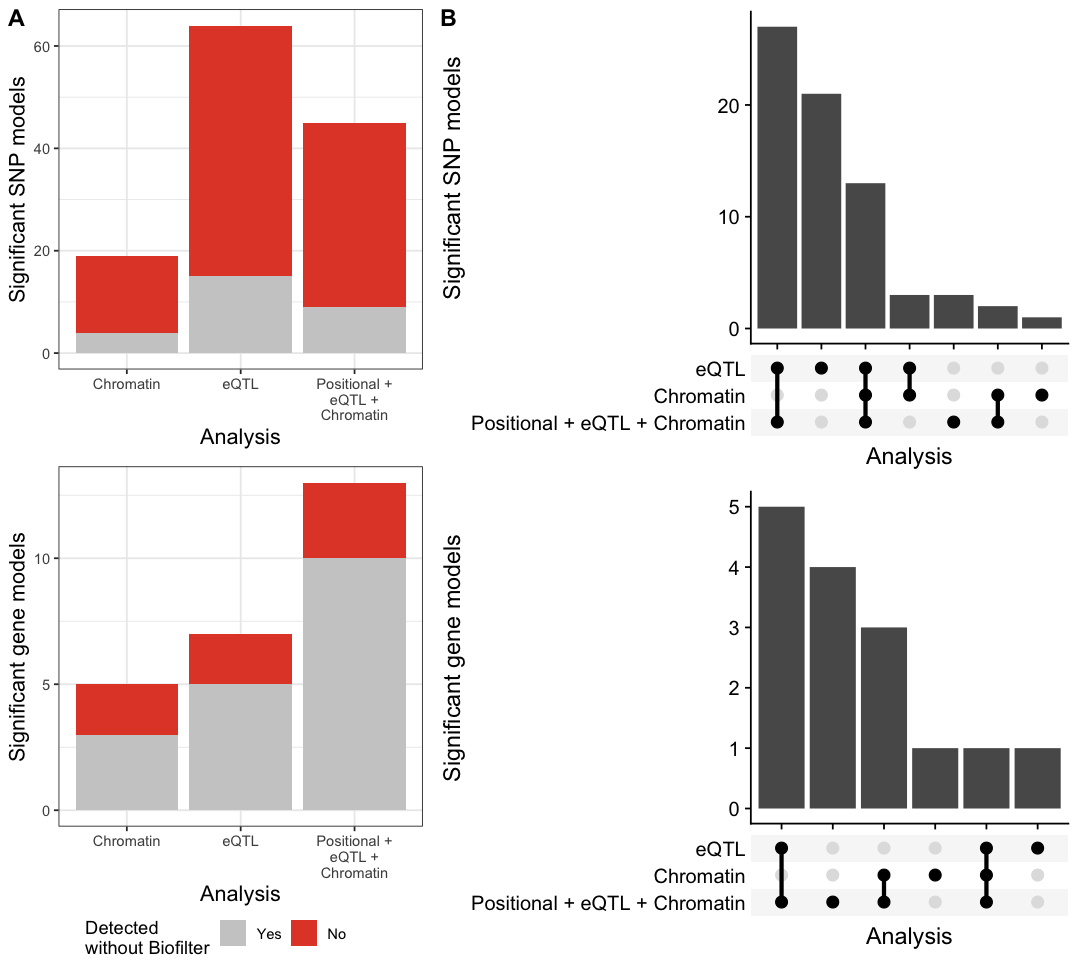

In [6]:
options(repr.plot.width=9, repr.plot.height=8)
plot_grid(plot_grid(plot_grid(snp_comparison + theme(legend.position = 'none'), 
                              gene_comparison, nrow = 2),
                    get_legend(snp_comparison),
                    nrow = 2, rel_heights = c(20,1)),
          plot_grid(filter_snp, filter_genes, nrow = 2),
          ncol = 2, rel_widths = c(1,1.5), labels = c('A','B'))
ggsave(filename = 'fig/superset_comparison.pdf', width=8, height=8, bg = "transparent")

In [7]:
bind_rows(read_snps('eqtl'),
          read_snps('chromatin'),
          read_snps('eqtl_chrom'),
          read_snps('eqtl_chrom_phys')) %>%
    group_by(uniq_snp_id) %>%
    summarize(eQTL = 'eqtl' %in% where,
              Chromatin = 'chromatin' %in% where,
              `eQTL + Chromatin` = 'eqtl_chrom' %in% where,
              `Positional + eQTL + Chromatin` = 'eqtl_chrom_phys' %in% where) %>%
    gather(key = 'where', value = 'detected', -uniq_snp_id) %>%
    group_by(uniq_snp_id) %>%
    filter(detected) %>%
    summarize(Analysis = paste(sort(where), collapse = '_')) %>%
    group_by(Analysis) %>%
    summarize(n = n())

Analysis,n
<chr>,<int>
Chromatin,1
Chromatin_eQTL + Chromatin_Positional + eQTL + Chromatin,2
Chromatin_eQTL_eQTL + Chromatin,3
Chromatin_eQTL_eQTL + Chromatin_Positional + eQTL + Chromatin,13
eQTL,20
eQTL + Chromatin,1
eQTL + Chromatin_Positional + eQTL + Chromatin,1
eQTL_eQTL + Chromatin,1
eQTL_eQTL + Chromatin_Positional + eQTL + Chromatin,27


In [8]:
all_snp_models <- read_csv(paste0(rslt, 'noFilter/sign_GenePairs.txt'), col_types = 'cdccd') %>%
    separate_rows(SNP1, sep = ' ') %>%
    separate_rows(SNP2, sep = ' ') %>%
    separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
    mutate(uniq_gene_id = make_key(gene1, gene2),
           uniq_snp_id = make_key(SNP1, SNP2)) %>%
    select(uniq_gene_id, uniq_snp_id) %>%
    unique

read_csv(paste0(rslt, 'noFilter/sign_SNPPairs.txt'), col_types = 'ccdccc') %>%
    mutate(uniq_snp_id = make_key(SNP_1, SNP_2),
           in_sign_gene = uniq_snp_id %in% all_snp_models$uniq_snp_id) %>%
    ggplot(aes(x = in_sign_gene)) +
        geom_histogram(stat = 'count')

ERROR: Error: '../results/noFilter/sign_GenePairs.txt' does not exist in current working directory ('/Users/hclimente/projects/BiologicalEpistasis/doc').
